<a href="https://colab.research.google.com/github/makkimaki/python-bayes-intro/blob/main/%E3%81%99%E3%82%89%E3%81%99%E3%82%89%E3%83%99%E3%82%A4%E3%82%BA%E5%86%99%E7%B5%8C_3%E2%88%923_%E3%80%90IRT_evaluation%E3%80%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IRT(Item Response Theory)によるテスト結果評価

本節の目的：**既存のモデル（統計モデル、機械学習モデル）ではない数学モデルから、ベイズモデルを構築する**

項目反応理論を取り上げ、この数学モデルをベイズ的に実装していく。

これまでと異なる点
1. 観測値データが表形式→従って、いずれ一次元化する加工が必要
2. 観測値データが膨大なため、推論に時間がかかる⇨短時間で行う方法として、変分推論法を活用

## IRTとは？
モデルはいくつも種類があるが、まずは**１パラメータ・ロジスティックモデル(1PLM)**の説明。
- 目的：受験者の能力値と、試験各設問の特性（困難度）を同時に予測する
- 受験者はそれぞれ個別の能力値を持つと考える
- 試験設問も、個別の困難度を持つとする
- 確率変数は、**能力値と困難度の関数**であると考える（ナイーブな考えでは、ある受験者の特定の設問に対する**正答率**が確率変数にするがここではそうしない）

本節では、2PLMを取り上げる。
- 設問固有のパラメータは、困難度だけでなく**識別力**もあると考える
    - 識別力：受験者のレベルを変えた時に、正答率がどの程度変化するかの度合いを示すパラメータ
- パラメータ一覧
$$ \theta_i: 能力値$$
$$ b_j: 困難度 $$
$$　a_j: 識別力$$
２PLMではシグモイド関数$f(x) = 1/(1+e^{-x})$を用いて
$$ f(a_j(\theta_i - b_j))$$
と表す。なお、この時の$f(x)$は正答率と解釈すれば良い。


In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=fff56a1e98f43cfae30951db6a3f5b809319f43cdd971fe1e0d5efb1247ec586
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.7.2'
sns.__version__='0.12.0'
np.__version__='1.23.5'


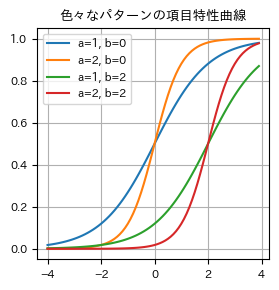

In [3]:
x = np.arange(-4, 4, 0.1)
abset = [(1, 0), (2, 0), (1, 2), (2, 2)]

def sigmoid(x, a=1, b=1):
    return 1 / (1 + np.exp(-a*(x-b)))

plt.figure()
for abitem in abset:
    a, b = abitem
    plt.plot(x, sigmoid(x, a=a, b=b), label=f"{a=}, {b=}")

plt.legend()
plt.title("色々なパターンの項目特性曲線")
plt.show()

↑各曲線は、それぞれ設問と考えて良い。（識別力、困難度）のセットで１つの設問になり、受験者$j$の能力値$\theta_j$に応じて**正答率**が変化する。

## 問題設定
受験者：1000  
設問：50  
正答：1  
誤答：0

目的：設問別の困難度・識別力と、受験者別の能力値を同時に推定する  
⇨**特に、見かけ状の点数が同じであっても、受験者の能力値の違いを導出することが可能になる
**

In [4]:
url = "https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv"
df = pd.read_csv(url, index_col=0)

print(df.shape)
display(df.head())

(1000, 50)


,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


### データ加工
表形式のデータを観測として確率モデルに渡すには、`pandas.melt`, `pandas.factorize`を活用する。


In [8]:
# meltで、横持ち形式を縦持ちに変換
response_df = pd.melt(
    df.reset_index(),
    id_vars="index",
    var_name="question",
    value_name="response"
)

# 列名indexをuserに変換
response_df = response_df.rename({"index": "user"}, axis=1)

# 要素数の変化を確認
print(f"元データ(df): , {df.shape}")
print(f"変換後データ(response_df): , {response_df.shape}\n")

display(response_df.head())

元データ(df): , (1000, 50)
変換後データ(response_df): , (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [11]:
user_idx, users = pd.factorize(response_df["user"])
question_idx, questions = pd.factorize(response_df["question"])

response = response_df["response"].values

# 結果確認
print("--- USER ---")
print(user_idx, len(user_idx))
print(users)
print("\n--- QUESTION ---")
print(question_idx, len(question_idx))
print(questions)
print("\n--- RESPONSE ---")
print(response, len(response))


--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000


↑`users`, `questions`, `response`をそれぞれ50000データずつ分けて作った。これをモデルに読み込ませることになる。

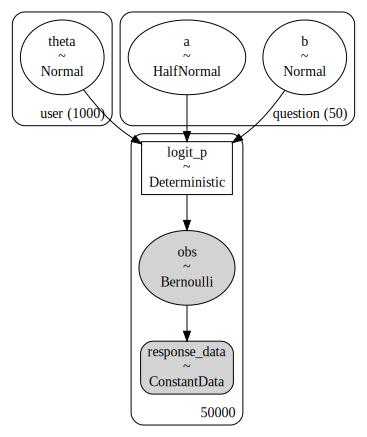

In [12]:
coords = {"user": users, "question": questions}

model1 = pm.Model(coords=coords)

with model1:
    response_data = pm.ConstantData("response_data", response)

    # 能力値
    theta = pm.Normal("theta", mu=0, sigma=1, dims="user")

    #　識別力
    a = pm.HalfNormal("a", sigma=1, dims="question")
    b = pm.Normal("b", mu=0, sigma=1, dims="question")

    logit_p = pm.Deterministic(
        "logit_p", a[question_idx] * (theta[user_idx] - b[question_idx])
        )
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model1)
display(g)